In [236]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

In [237]:
canoe_results = 'canoe_trn_lifetimes'
scenario_name = 'trn_lifetimes'

# Import CEF2023 tables
https://open.canada.ca/data/en/dataset/7643c948-d661-4d90-ab91-e9ac732fc737

In [238]:
model_years = [2021, 2025, 2030, 2035, 2040, 2045, 2050]

cef23_demand = pd.read_csv('cef2023_data/end-use-demand-2023.csv', index_col=0) #   Energy in PJ
bau23_demand = cef23_demand[(cef23_demand['Region'] == 'Ontario') & (cef23_demand['Scenario'] == 'Current Measures') &
                            (cef23_demand['Year'].isin(model_years))].sort_values(['Sector', 'Variable', 'Year'])
bau23_demand.rename(columns={'Value': 'Demand (PJ)', 'Variable': 'Carrier', 'Year': 'Period'}, inplace=True)
bau23_demand['Carrier'].replace({'Motor Gasoline': 'Gasoline', 'Hydrogen': 'H2'}, inplace=True)
bau23_demand['Period'] = bau23_demand['Period'].astype(str)

cef23_h2 = pd.read_csv('cef2023_data/hydrogen-production-2023.csv', index_col=0)
bau23_h2 = cef23_h2[(cef23_h2['Region'] == 'Ontario') & (cef23_h2['Scenario'] == 'Current Measures') &
                            (cef23_h2['Year'].isin(model_years))].sort_values(['Variable', 'Year'])
bau23_h2.rename(columns={'Value': 'Production (Mt)', 'Variable': 'Pathway', 'Year': 'Period'}, inplace=True)
bau23_h2['Period'] = bau23_h2['Period'].astype(str)
bau23_h2['Pathway'] = bau23_h2['Pathway'].replace({'Natural gas with CCS': 'SMR w CCS'})

cef23_gen = pd.read_csv('cef2023_data/electricity-generation-2023.csv', index_col=0)
bau23_gen = cef23_gen[(cef23_gen['Region'] == 'Ontario') & (cef23_gen['Scenario'] == 'Current Measures') &
                            (cef23_gen['Year'].isin(model_years))].sort_values(['Variable', 'Year'])
bau23_gen.rename(columns={'Value': 'Generation (GWh)', 'Variable': 'Plant Type', 'Year': 'Period'}, inplace=True)
bau23_gen['Period'] = bau23_gen['Period'].astype(str)

cef23_cap = pd.read_csv('cef2023_data/electricity-capacity-2023.csv')
bau23_cap = cef23_cap[(cef23_cap['Region'] == 'Ontario') & (cef23_cap['Scenario'] == 'Current Measures') &
                            (cef23_cap['Year'].isin(model_years))].sort_values(['Variable', 'Year'])
bau23_cap.rename(columns={'Value': 'Capacity (MW)', 'Variable': 'Plant Type', 'Year': 'Period'}, inplace=True)
bau23_cap['Period'] = bau23_cap['Period'].astype(str)

C:\Users\rashi\AppData\Local\Temp\ipykernel_31072\1259712670.py:7: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





# Import gTech-IESD results

In [239]:
years = pd.DataFrame({'year': range(2020, 2051)})

def import_navius_data(df):
    df = df[(df['policy'] == 'legislated') & (df['swb'] == 'ref') & (df['ccs'] == 'ref') & (df['hyd'] == 'ref') & 
            (df['oil'] == 'ref') & (df['dac'] == 'no')].drop(columns=['region', 'policy', 'swb', 'ccs', 'hyd', 'oil', 'dac', 'lul']).reset_index(drop='index')
    labels = list(set(df.columns.to_list()) - set(['year', 'value']))
    unique_combinations = df[labels].drop_duplicates()
    expanded_df = unique_combinations.assign(key=1).merge(years.assign(key=1), on='key').drop('key', axis=1)
    merged_df = expanded_df.merge(df, on=['year'] + labels, how='left')
    merged_df = merged_df.sort_values(by=labels + ['year'])
    merged_df['value'] = merged_df.groupby(labels, as_index=False)['value'].apply(lambda group: group.interpolate()).reset_index(level=0, drop=True)
    interpolated_2021 = merged_df[merged_df['year'] == 2021]
    df = pd.concat([df, interpolated_2021]).sort_values(by=['year'] + labels).reset_index(drop=True)
    return df[df['year'] != 2020]

In [240]:
gtech23_vehshare = pd.read_csv('navius_regional_data_on/total market share of vehicles by type (%).csv', usecols=lambda column: column != 'id')
gtech23_ref_vehshare = import_navius_data(gtech23_vehshare)
gtech23_ref_vehshare.rename(columns={'year': 'Period', 'value': 'Market Share (%)', 'eu_name': 'Class', 'technology': 'Drivetrain'}, inplace=True)
gtech23_ref_vehshare['Class'] = gtech23_ref_vehshare['Class'].replace({'light-duty': 'LDV', 'heavy-duty': 'HDV'})
gtech23_ref_vehshare['Drivetrain'] = gtech23_ref_vehshare['Drivetrain'].replace({'fcev': 'FCEV', 'ice': 'ICEV', 'bev': 'BEV'})

gtech23_demand = pd.read_csv('navius_regional_data_on/energy consumption by sector (PJ).csv', usecols=lambda column: column != 'id')
gtech23_ref_demand = import_navius_data(gtech23_demand)
gtech23_ref_demand.rename(columns={'year': 'Period', 'value': 'Demand (PJ)', 'sector': 'Sector'}, inplace=True)

gtech23_ghg = pd.read_csv('navius_regional_data_on/emissions by sector (Mt).csv', usecols=lambda column: column != 'id')
gtech23_ref_ghg = import_navius_data(gtech23_ghg)
gtech23_ref_ghg.rename(columns={'year': 'Period', 'value': 'CO2e (Mt)', 'sector': 'Sector'}, inplace=True)

gtech23_gen = pd.read_csv('navius_regional_data_on/electricity generation by source (TWh).csv', usecols=lambda column: column != 'id')
gtech23_ref_gen = import_navius_data(gtech23_gen)
gtech23_ref_gen.rename(columns={'year': 'Period', 'value': 'Generation (TWh)', 'type': 'Plant Type'}, inplace=True)

gtech23_cap = pd.read_csv('navius_regional_data_on/electricity capacity by source (MW).csv', usecols=lambda column: column != 'id')
gtech23_ref_cap = import_navius_data(gtech23_cap)
gtech23_ref_cap.rename(columns={'year': 'Period', 'value': 'Capacity (MW)', 'type': 'Plant Type'}, inplace=True)
gtech23_ref_cap['Plant Type'] = gtech23_ref_cap['Plant Type'].replace({'fcev': 'FCEV', 'ice': 'ICEV', 'bev': 'BEV'})

gtech23_h2 = pd.read_csv('navius_regional_data_on/hydrogen production by type (PJ).csv', usecols=lambda column: column != 'id')
gtech23_ref_h2 = import_navius_data(gtech23_h2)
gtech23_ref_h2.rename(columns={'year': 'Period', 'value': 'Production (PJ)', 'prod_type': 'Pathway'}, inplace=True)
gtech23_ref_h2['Pathway'] = gtech23_ref_h2['Pathway'].replace({'electrolysis': 'Electrolysis', 'smr with ccs': 'SMR w CCS'})

In [241]:
gtech23_ref_demand['Sector'].replace({'agriculture & waste': 'Agriculture', 'commercial buildings': 'Commercial', 'residential buildings': 'Residential', 
                                      'industry': 'Industrial', 'oil and gas': 'Oil & Gas', 'direct air capture': 'Industrial', 'Utilities': 'Utilities',
                                      'light-duty transport': 'Transportation', 'medium & heavy-duty transport': 'Transportation', 'other transport': 'Transportation'}, inplace=True)
gtech23_ref_demand = gtech23_ref_demand.groupby(['Period', 'Sector'], as_index=False).sum()[['Period', 'Sector', 'Demand (PJ)']]

C:\Users\rashi\AppData\Local\Temp\ipykernel_31072\2137638342.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





# Import Canoe results

In [242]:
ref_file = canoe_results + '/' + scenario_name + '.xlsx'

ref_trnact = pd.read_excel(ref_file, sheet_name='Activity_Transport').fillna(0)
ref_trncap = pd.read_excel(ref_file, sheet_name='Capacity_Transport').fillna(0)
ref_trnnewcap = pd.read_excel(ref_file, sheet_name='NewCapacity_Transport').fillna(0)

ref_trnact = pd.read_excel(ref_file, sheet_name='Activity_Transport').fillna(0)
ref_resact = pd.read_excel(ref_file, sheet_name='Activity_residential').fillna(0)
ref_commact = pd.read_excel(ref_file, sheet_name='Activity_commercial').fillna(0)
ref_indact = pd.read_excel(ref_file, sheet_name='Activity_industrial').fillna(0)

ref_elcact = pd.read_excel(ref_file, sheet_name='Activity_electricity').fillna(0)
ref_elccap = pd.read_excel(ref_file, sheet_name='Capacity_electricity').fillna(0)
ref_elcnewcap = pd.read_excel(ref_file, sheet_name='NewCapacity_electricity').fillna(0)

ref_ghg = pd.read_excel(ref_file, sheet_name='Emissions').fillna(0)
ref_costs = pd.read_excel(ref_file, sheet_name='Costs').fillna(0)

In [243]:
class_mapping = {
    'T_HDV_AJ': 'Air jet',
    'T_HDV_B': 'Bus',
    'T_HDV_R': 'Rail',
    'T_HDV_T': 'HD Truck',
    'T_HDV_W': 'Marine vessel',
    'T_MDV_T': 'MD Truck',
    'T_LDV_C_': 'LD Car',
    'T_LDV_LT': 'LD Truck',
    'T_LDV_M': 'Motorcycle',
    'T_IMP_': 'Fuel use',
    'H2_distribution': 'Fuel use'
}

def map_tech_to_mode(tech):
    for prefix, class_name in class_mapping.items():
        if tech.startswith(prefix):
            return class_name
    return 'Other'

ref_trnact['Mode'] = ref_trnact['Technology'].apply(map_tech_to_mode)
ref_trncap['Mode'] = ref_trncap['Technology'].apply(map_tech_to_mode)
ref_trnnewcap['Mode'] = ref_trnnewcap['Technology'].apply(map_tech_to_mode)

In [244]:
carrier_mapping = {
        'BEV': 'BEV',
        'GSL': 'Gasoline',
        'DSL': 'Diesel',
        'CNG': 'CNG',
        'LNG': 'LNG',
        'JTF': 'Aviation Fuel',
        'SPK': 'Synthetic Kerosene', #  Might change for SAF
        'HFO': 'Heavy Fuel Oil',
        'MDO': 'Marine Diesel Oil',
        'H2': 'H2',
        'ELC': 'Electricity'
    }

def map_tech_to_drivetrain(tech):
    # Check hybrids first
    if 'PHEV' in tech:
        return 'PHEV'
    if 'FC' in tech:
        return 'FCEV'
    if 'HEV' in tech:
        return 'HEV'
    if 'RDSL' in tech:
            return 'Renewable Diesel' #     Might differentiate
    if 'ETH' in tech:
        return 'Ethanol' #                  Might differentiate
    for prefix, carrier in carrier_mapping.items():
        if prefix in tech:
            return carrier 
    return 'Other'

ref_trnact['Carrier'] = ref_trnact['Technology'].apply(map_tech_to_drivetrain)
ref_trncap['Carrier'] = ref_trncap['Technology'].apply(map_tech_to_drivetrain)
ref_trnnewcap['Carrier'] = ref_trnnewcap['Technology'].apply(map_tech_to_drivetrain)

# Demand graph template

## CANOE ref vs CEF 2023 current policies - transport energy demand by carrier

In [245]:
def carrier_grouping(carrier):
    if carrier == 'CNG':
        return 'Natural Gas'
    if carrier == 'LNG':
        return 'Natural Gas'
    if carrier == 'Ethanol':
        return 'Biofuels'
    if carrier == 'Renewable Diesel':
        return 'Biofuels'
    if carrier == 'Synthetic Kerosene':
        return 'Biofuels'
    if carrier == 'Heavy Fuel Oil':
        return 'Marine Fuels'
    if carrier == 'Marine Diesel Oil':
        return 'Marine Fuels'
    if carrier == 'LPG':
        return 'Other'
    if carrier == 'Lubricants':
        return 'Other'
    else: return carrier

In [246]:
ref_trnact.columns = ref_trnact.columns.astype(str)
periods = [col for col in ref_trnact.columns if col.isdigit()]
params = [col for col in ref_trnact.columns if not col.isdigit()]
ref_trnact = pd.melt(ref_trnact, id_vars=params, var_name='Period', value_name='Demand (PJ)', value_vars=periods)

In [247]:
bau23_fig = bau23_demand[(bau23_demand['Sector'] == 'Transportation') & (bau23_demand['Carrier'] != 'Total End-Use')].copy()
ref_fig = ref_trnact[(ref_trnact['Mode'] == 'Fuel use') & (ref_trnact['Carrier'] != 'Other')].copy()
carrier_order = ['Gasoline', 'Diesel', 'Biofuels', 'Electricity', 'H2', 'Natural Gas', 'Aviation Fuel', 'Marine Fuels', 'Other']

bau23_fig['Source'] = 'CEF2023'
ref_fig['Source'] = 'CANOE'
fig_df = pd.concat([ref_fig[['Period', 'Demand (PJ)', 'Carrier', 'Source']], bau23_fig[['Period', 'Demand (PJ)', 'Carrier', 'Source']]])

fig_df['Carrier'] = fig_df['Carrier'].apply(carrier_grouping)
fig_df = fig_df.groupby(['Period', 'Carrier', 'Source'], as_index=False).sum('Demand (PJ)')
fig_df['Carrier'] = pd.Categorical(fig_df['Carrier'], categories=carrier_order, ordered=True)
fig_df = fig_df.sort_values(['Carrier', 'Period'])

fig = px.bar(fig_df, 
             x='Source', 
             y='Demand (PJ)', 
             color='Carrier', 
             barmode='stack', 
             facet_col='Period',
             facet_col_spacing=2E-2,
             template='plotly_white',
             color_discrete_sequence=px.colors.qualitative.G10[:7] + px.colors.qualitative.G10[8:],
             text_auto='.1f',
            #  text='Demand (PJ)_sum'
             width=1150, height=650,
             )

fig.update_layout(title=dict(
        text='Transportation secondary energy demand in ON by carrier and energy model',
        x=0.5, 
        y=0.97,
        xanchor='center',
        yanchor='top'
    ),
    xaxis=dict(title='Period'),
    yaxis=dict(title='Demand (PJ)',
               dtick=100),
    yaxis_title_standoff=0,
    legend_title_text='',
    bargap=0.1,
    legend=dict(
        orientation='h',  
        yanchor='top',
        y=1.04,  
        xanchor='center',
        x=0.5),
    font=dict(
        # family="Open Sans",
        size=14)
    )

for annotation in fig.layout.annotations:
    annotation.text = annotation.text.split('=')[1]
    annotation.y = -0.05  
    annotation.yanchor = 'top' 

for axis in fig.layout:
    if axis.startswith('yaxis'):
        fig.layout[axis].dtick = 100

for axis in fig.layout:
    if axis.startswith('xaxis'):
        fig.layout[axis].title.text = ''

fig.for_each_trace(lambda trace: trace.update(textfont=dict(size=9)))

fig.show()
# fig.write_image("trn_demand.svg", scale=1, engine='kaleido')

# CANOE vs CEF2023 vs gTech-IESD - transportation secondary energy demand

In [248]:
gtech23_ref_demand['Sector'].replace({'agriculture & waste': 'AFOLU', 'commercial buildings': 'Commercial', 'residential buildings': 'Residential', 'land use & forestry': 'AFOLU',
                                      'industry': 'Industrial', 'oil and gas': 'Oil & Gas', 'direct air capture': 'Industrial', 'utilities': 'Utilities',
                                      'light-duty transport': 'Transportation', 'medium & heavy-duty transport': 'Transportation', 'other transport': 'Transportation'}, inplace=True)
gtech23_ref_demand = gtech23_ref_demand.groupby(['Period', 'Sector'], as_index=False).sum()[['Period', 'Sector', 'Demand (PJ)']]

C:\Users\rashi\AppData\Local\Temp\ipykernel_31072\4239646409.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [249]:
bau23_fig = bau23_demand[(bau23_demand['Sector'] == 'Transportation') & (bau23_demand['Carrier'] == 'Total End-Use')].copy()
ref_fig = ref_trnact[(ref_trnact['Mode'] == 'Fuel use') & (ref_trnact['Carrier'] != 'Other')].groupby('Period', as_index=False).sum('Demand (PJ)')
gtech_fig = gtech23_ref_demand[gtech23_ref_demand['Sector'] == 'Transportation'].copy()

bau23_fig['Source'] = 'CEF 2023'
ref_fig['Source'] = 'CANOE'
gtech_fig['Source'] = 'gTech-IESD'
fig_df = pd.concat([ref_fig[['Period', 'Demand (PJ)', 'Source']], bau23_fig[['Period', 'Demand (PJ)', 'Source']], gtech_fig[['Period', 'Demand (PJ)', 'Source']]]).reset_index(drop=True)

fig = px.line(fig_df, x='Period', y='Demand (PJ)', color='Source',
              template='plotly_white',
              width=800, height=450
              )

fig.update_layout(
    title=dict(text='Transportation total energy demand in ON by energy model',
               x=0.5,
               y=0.95,
               xanchor='center',
               yanchor='top'
               ),
    xaxis=dict(title='Period'),
    yaxis=dict(title='Demand (PJ)'),
    yaxis_title_standoff=0,
    legend_title_text='',
    bargap=0.1,
    legend=dict(orientation='h',
                yanchor='bottom',
                y=-0.16,
                xanchor='center',
                x=0.5),
    font=dict(size=14,
              # family="Open Sans"
              ))

for annotation in fig.layout.annotations:
    annotation.text = annotation.text.split('=')[1]
    annotation.y = -0.05  
    annotation.yanchor = 'top' 

for axis in fig.layout:
    if axis.startswith('xaxis'):
        fig.layout[axis].title.text = ''

fig.show()

# CANOE - transportation vehicle capacity

In [250]:
ref_trncap.columns = ref_trncap.columns.astype(str)
periods = [col for col in ref_trncap.columns if col.isdigit()]
params = [col for col in ref_trncap.columns if not col.isdigit()]
ref_trncap = pd.melt(ref_trncap, id_vars=params, var_name='Period', value_name='Capacity (M units)', value_vars=periods)
ref_trncap['Capacity (M units)'] = ref_trncap['Capacity (M units)']/1E3

In [251]:
def veh_class_mapping(veh_class):
    if veh_class == 'Air jet':
        return 'Other'
    if veh_class == 'Rail':
        return 'Other'
    if veh_class == 'Marine vessel':
        return 'Other'
    if veh_class == 'Motorcycle':
        return 'Other'
    if veh_class == 'Fuel use':
        return 'Other'
    else: return veh_class
    
ref_trncap['Vehicle Class'] = ref_trncap['Mode'].apply(veh_class_mapping)

drivetrain_order = ['Gasoline', 'Diesel', 'CNG', 'HEV', 'PHEV', 'BEV', 'FCEV']

In [252]:
ref_fig = ref_trncap[ref_trncap['Vehicle Class'].isin(['LD Car', 'LD Truck'])][['Period', 'Vehicle Class', 'Capacity (M units)', 'Carrier']].groupby(['Period', 'Vehicle Class', 'Carrier'], as_index=False).sum()

ref_fig['Carrier'] = pd.Categorical(ref_fig['Carrier'], categories=drivetrain_order, ordered=True)
ref_fig = ref_fig.sort_values(['Carrier', 'Period'])

fig = px.bar(ref_fig, 
             x='Vehicle Class', 
             y='Capacity (M units)', 
             color='Carrier', 
             barmode='stack', 
             facet_col='Period',
             facet_col_spacing=2E-2,
             template='plotly_white',
             color_discrete_sequence=px.colors.qualitative.G10[:7] + px.colors.qualitative.G10[8:],
             text_auto='.2f',
            #  text='Demand (PJ)_sum'
             width=1000, height=650,
             )

fig.update_layout(title=dict(
        text='Transportation LDV fleet stock in ON by vehicle class and drivetrain',
        x=0.5, 
        y=0.97,
        xanchor='center',
        yanchor='top'
    ),
    xaxis=dict(title='Period'),
    yaxis=dict(title='Fleet stock (M units)',
               dtick=1),
    yaxis_title_standoff=0,
    legend_title_text='',
    bargap=0.1,
    legend=dict(
        orientation='h',  
        yanchor='top',
        y=1.03,  
        xanchor='center',
        x=0.5),
    font=dict(
        # family="Open Sans",
        size=14)
    )

for annotation in fig.layout.annotations:
    annotation.text = annotation.text.split('=')[1]
    annotation.y = -0.08  
    annotation.yanchor = 'top' 

for axis in fig.layout:
    if axis.startswith('yaxis'):
        fig.layout[axis].dtick = 1

for axis in fig.layout:
    if axis.startswith('xaxis'):
        fig.layout[axis].title.text = ''

fig.for_each_trace(lambda trace: trace.update(textfont=dict(size=9)))

fig.show()

In [253]:
ref_fig = ref_trncap[ref_trncap['Vehicle Class'].isin(['MD Truck', 'HD Truck', 'Bus'])][['Period', 'Vehicle Class', 'Capacity (M units)', 'Carrier']].groupby(['Period', 'Vehicle Class', 'Carrier'], as_index=False).sum()
ref_fig['Capacity (k units)'] = ref_fig['Capacity (M units)']*1E3

ref_fig['Carrier'] = pd.Categorical(ref_fig['Carrier'], categories=drivetrain_order, ordered=True)
ref_fig = ref_fig.sort_values(['Carrier', 'Period'])

fig = px.bar(ref_fig, 
             x='Vehicle Class', 
             y='Capacity (k units)', 
             color='Carrier', 
             barmode='stack', 
             facet_col='Period',
             facet_col_spacing=2E-2,
             template='plotly_white',
             color_discrete_sequence=px.colors.qualitative.G10[:7] + px.colors.qualitative.G10[8:],
             text_auto='.1f',
            #  text='Demand (PJ)_sum'
             width=1150, height=650,
             )

fig.update_layout(title=dict(
        text='Transportation MHDV fleet stock in ON by vehicle class and drivetrain',
        x=0.5, 
        y=0.97,
        xanchor='center',
        yanchor='top'
    ),
    xaxis=dict(title='Period'),
    yaxis=dict(title='Fleet stock (k units)',
               dtick=100),
    yaxis_title_standoff=0,
    legend_title_text='',
    bargap=0.1,
    legend=dict(
        orientation='h',  
        yanchor='top',
        y=1.02,  
        xanchor='center',
        x=0.5),
    font=dict(
        # family="Open Sans",
        size=14)
    )

for annotation in fig.layout.annotations:
    annotation.text = annotation.text.split('=')[1]
    annotation.y = -0.1  
    annotation.yanchor = 'top' 

for axis in fig.layout:
    if axis.startswith('xaxis'):
        fig.layout[axis].title.text = ''

fig.for_each_trace(lambda trace: trace.update(textfont=dict(size=9)))

fig.show()

# Added Capacity

In [254]:
# ref_file = canoe_results + '/builtcapacity.csv'
# ref_newcap = pd.read_csv(ref_file)
# ref_newcap.rename(columns={'sector': 'Sector', 'tech': 'Technology', 'vintage': 'Period', 'capacity': 'New Capacity'}, inplace=True)

# ref_newcap_trn = ref_newcap[(ref_newcap['Sector'] == 'Transport')].copy()
# ref_newcap_trn['Mode'] = ref_newcap_trn['Technology'].apply(map_tech_to_mode)
# ref_newcap_trn['Carrier'] = ref_newcap_trn['Technology'].apply(map_tech_to_drivetrain)
# ref_newcap_trn['Vehicle Class'] = ref_newcap_trn['Mode'].apply(veh_class_mapping)

In [255]:
ref_trnnewcap.columns = ref_trnnewcap.columns.astype(str)
periods = [col for col in ref_trnnewcap.columns if col.isdigit()]
params = [col for col in ref_trnnewcap.columns if not col.isdigit()]
ref_trnnewcap = pd.melt(ref_trnnewcap, id_vars=params, var_name='Period', value_name='New Capacity', value_vars=periods)

ref_trnnewcap['Vehicle Class'] = ref_trnnewcap['Mode'].apply(veh_class_mapping)

In [256]:
ref_fig = ref_trnnewcap[ref_trnnewcap['Vehicle Class'].isin(['LD Car', 'LD Truck'])][['Period', 'Vehicle Class', 'New Capacity', 'Carrier']].groupby(['Period', 'Vehicle Class', 'Carrier'], as_index=False).sum()
ref_fig['New Capacity (M units)'] = ref_fig['New Capacity']/1E3

ref_fig['Carrier'] = pd.Categorical(ref_fig['Carrier'], categories=drivetrain_order, ordered=True)
ref_fig = ref_fig.sort_values(['Carrier', 'Period'])

fig = px.bar(ref_fig, 
             x='Vehicle Class', 
             y='New Capacity', 
             color='Carrier', 
             barmode='stack', 
             facet_col='Period',
             facet_col_spacing=2E-2,
             template='plotly_white',
             color_discrete_sequence=px.colors.qualitative.G10[:7] + px.colors.qualitative.G10[8:],
             text_auto='.1f',
             width=1000, height=650,
             )

fig.update_layout(title=dict(
        text='Transportation fleet expansion in ON by vehicle class and drivetrain',
        x=0.5, 
        y=0.97,
        xanchor='center',
        yanchor='top'
    ),
    xaxis=dict(title='Period'),
    yaxis=dict(title='New vehicles (k units)',
               dtick=500),
    yaxis_title_standoff=0,
    legend_title_text='',
    bargap=0.1,
    legend=dict(
        orientation='h',  
        yanchor='top',
        y=1.03,  
        xanchor='center',
        x=0.5),
    font=dict(
        # family="Open Sans",
        size=14)
    )

for annotation in fig.layout.annotations:
    annotation.text = annotation.text.split('=')[1]
    annotation.y = -0.08  
    annotation.yanchor = 'top' 

for axis in fig.layout:
    if axis.startswith('xaxis'):
        fig.layout[axis].title.text = ''

fig.for_each_trace(lambda trace: trace.update(textfont=dict(size=9)))

fig.show()

In [257]:
ref_fig = ref_trnnewcap[ref_trnnewcap['Vehicle Class'].isin(['Bus', 'MD Truck', 'HD Truck'])][['Period', 'Vehicle Class', 'New Capacity', 'Carrier']].groupby(['Period', 'Vehicle Class', 'Carrier'], as_index=False).sum()
ref_fig['New Capacity (M units)'] = ref_fig['New Capacity']/1E3

ref_fig['Carrier'] = pd.Categorical(ref_fig['Carrier'], categories=drivetrain_order, ordered=True)
ref_fig = ref_fig.sort_values(['Carrier', 'Period'])

fig = px.bar(ref_fig, 
             x='Vehicle Class', 
             y='New Capacity', 
             color='Carrier', 
             barmode='stack', 
             facet_col='Period',
             facet_col_spacing=2E-2,
             template='plotly_white',
             color_discrete_sequence=px.colors.qualitative.G10[:7] + px.colors.qualitative.G10[8:],
             text_auto='.1f',
             width=1000, height=650,
             )

fig.update_layout(title=dict(
        text='Transportation fleet expansion in ON by vehicle class and drivetrain',
        x=0.5, 
        y=0.97,
        xanchor='center',
        yanchor='top'
    ),
    xaxis=dict(title='Period'),
    yaxis=dict(title='New vehicles (k units)',
               dtick=20),
    yaxis_title_standoff=0,
    legend_title_text='',
    bargap=0.1,
    legend=dict(
        orientation='h',  
        yanchor='top',
        y=1.03,  
        xanchor='center',
        x=0.5),
    font=dict(
        # family="Open Sans",
        size=14)
    )

for annotation in fig.layout.annotations:
    annotation.text = annotation.text.split('=')[1]
    annotation.y = -0.08  
    annotation.yanchor = 'top' 

for axis in fig.layout:
    if axis.startswith('yaxis'):
        fig.layout[axis].dtick = 20

for axis in fig.layout:
    if axis.startswith('xaxis'):
        fig.layout[axis].title.text = ''

fig.for_each_trace(lambda trace: trace.update(textfont=dict(size=9)))

fig.show()

In [258]:
gtech_class_mapping = {
    'LD Car': 'LDV',
    'LD Truck': 'LDV',
    'HD Truck': 'HDV',
}

gtech_carrier_mapping = {
    'CNG': 'ICEV',
    'HEV': 'ICEV',
    'PHEV': 'ICEV',
    'Diesel': 'ICEV',
    'Gasoline': 'ICEV',
    'BEV': 'BEV',
    'FCEV': 'FCEV',
}

In [259]:
ref_fig = ref_trnnewcap[ref_trnnewcap['Vehicle Class'].isin(['LD Car', 'LD Truck', 'HD Truck'])][['Period', 'Carrier', 'Vehicle Class', 'New Capacity']]
ref_fig['Carrier'] = ref_fig.Carrier.map(gtech_carrier_mapping)
ref_fig['Vehicle Class'] = ref_fig['Vehicle Class'].map(gtech_class_mapping)
ref_fig = ref_fig.groupby(['Period', 'Carrier', 'Vehicle Class'], as_index=False).sum()

veh_tot_cap = ref_fig.groupby(['Period', 'Vehicle Class'], as_index=False).sum('New Capacity')
ref_fig = pd.merge(ref_fig, veh_tot_cap, on=['Period', 'Vehicle Class'], suffixes=('', '_sum'))
ref_fig['Market Share (%)'] = ref_fig['New Capacity'] / ref_fig['New Capacity_sum'] * 100
ref_fig.rename(columns={'Vehicle Class': 'Class', 'Carrier': 'Drivetrain'}, inplace=True)

ref_fig['Model'] = 'CANOE (ref)'
gtech23_ref_vehshare['Model'] = 'gTech-IESD (ref)'
gtech23_ref_vehshare['Period'] = gtech23_ref_vehshare['Period'].astype(str)
fig_df = pd.concat([ref_fig[['Period', 'Class', 'Drivetrain', 'Model', 'Market Share (%)']], gtech23_ref_vehshare[['Period', 'Class', 'Drivetrain', 'Model', 'Market Share (%)']]]).reset_index(drop=True)
fig_df['Class'] = pd.Categorical(fig_df['Class'], categories=['LDV', 'HDV'], ordered=True)
fig_df = fig_df.sort_values(['Class', 'Period'])

fig = px.area(fig_df, x='Period', y='Market Share (%)', color='Drivetrain', facet_col='Model', facet_row='Class',
              template='plotly_white',
              facet_col_spacing=0.05,
              facet_row_spacing=0.03,
              width=900, height=500
              )

fig.update_layout(
    title=dict(text='RT vehicle market share by weight class, drivetrain and energy model in ON',
               x=0.5,
               y=0.97,
               xanchor='center',
               yanchor='top'
               ),
    xaxis=dict(title='Period'),
    yaxis=dict(title='Market Share (%)'),
    yaxis_title_standoff=0,
    legend_title_text='',
    bargap=0.1,
    legend=dict(orientation='h',
                yanchor='top',
                y=0.99,
                xanchor='center',
                x=0.5),
    font=dict(size=14,
              # family="Open Sans"
              ))

for axis in fig.layout:
    if axis.startswith('yaxis'):
        fig.layout[axis].title.text = ''
    if axis.startswith('xaxis'):
        fig.layout[axis].title.text = ''

fig.update_xaxes(tickangle=45)

fig.add_annotation(
    text="Market Share (%)",
    x=-0.08,  # Adjust x position as needed
    y=0.5,
    xref="paper",
    yref="paper",
    showarrow=False,
    textangle=-90,
    font=dict(size=15))

fig.show()
fig.write_image("market_shares.svg", scale=1, engine='kaleido')

# CANOE vs CEF 2023 vs gTech-IESD - power generation capacity and activity

In [260]:
plant_mapping = {
    'E_BIO': 'Biomass',
    'E_NG': 'Natural Gas',
    'E_HYD': 'Hydro',
    'E_SOL': 'Solar',
    'E_WND': 'Wind',
    'E_NUC': 'Nuclear',
}

def map_tech_to_plant(tech):
    for prefix, plant_name in plant_mapping.items():
        if tech.startswith(prefix):
            return plant_name
    return 'Other'

ref_elcact['Plant Type'] = ref_elcact['Technology'].apply(map_tech_to_plant)
ref_elccap['Plant Type'] = ref_elccap['Technology'].apply(map_tech_to_plant)

In [261]:
ref_elccap.columns = ref_elccap.columns.astype(str)
periods = [col for col in ref_elccap.columns if col.isdigit()]
params = [col for col in ref_elccap.columns if not col.isdigit()]
ref_elccap = pd.melt(ref_elccap, id_vars=params, var_name='Period', value_name='Capacity (GW)', value_vars=periods)

In [262]:
def plant_rename(type):
    if type == 'hydro':
        return 'Hydro'
    if type == 'natural gas':
        return 'Natural Gas'
    if type == 'natural gas w ccs':
        return 'Natural Gas'
    if type == 'nuclear':
        return 'Nuclear'
    if type == 'solar':
        return 'Solar'
    if type == 'wind':
        return 'Wind'
    else: return 'Other'
    
gtech23_ref_cap['Plant Type'] = gtech23_ref_cap['Plant Type'].apply(plant_rename)
gtech23_ref_cap = gtech23_ref_cap.groupby(['Period', 'Plant Type'], as_index=False).sum()

In [263]:
bau23_cap['Capacity (GW)'] = bau23_cap['Capacity (MW)'] / 1E3
bau23_fig = bau23_cap[['Period', 'Plant Type', 'Capacity (GW)']].copy()
bau23_fig['Plant Type'] = bau23_fig['Plant Type'].replace({'Hydro / Wave / Tidal': 'Hydro', 'Biomass / Geothermal': 'Biomass', 'Uranium': 'Nuclear'})
ref_fig = ref_elccap[ref_elccap['Plant Type'] != 'Other'].groupby(['Period', 'Plant Type'], as_index=False).sum('Capacity (GW)')
gtech23_ref_cap['Capacity (GW)'] = gtech23_ref_cap['Capacity (MW)'] / 1E3
gtech23_fig = gtech23_ref_cap.copy()
gtech23_fig['Period'] = gtech23_fig['Period'].astype(str)

gtech23_fig['Source'] = 'gTech-IESD'
bau23_fig['Source'] = 'CEF2023'
ref_fig['Source'] = 'CANOE'
fig_df = pd.concat([ref_fig[['Period', 'Plant Type', 'Capacity (GW)', 'Source']], bau23_fig[['Period', 'Plant Type', 'Capacity (GW)', 'Source']], gtech23_fig[['Period', 'Plant Type', 'Capacity (GW)', 'Source']]])

fig = px.bar(fig_df, 
             x='Source', 
             y='Capacity (GW)', 
             color='Plant Type', 
             barmode='stack', 
             facet_col='Period',
             facet_col_spacing=2E-2,
             template='plotly_white',
             color_discrete_sequence=px.colors.qualitative.G10[:7] + px.colors.qualitative.G10[8:],
             text_auto='.1f',
             width=1200, height=650,
             )

fig.update_layout(title=dict(
        text='Electricity generation capacity in ON by plant type and energy model',
        x=0.5, 
        y=0.97,
        xanchor='center',
        yanchor='top'
    ),
    xaxis=dict(title='Period'),
    yaxis=dict(title='Capacity (GW)',
               dtick=20),
    yaxis_title_standoff=0,
    legend_title_text='',
    bargap=0.1,
    legend=dict(
        orientation='h',  
        yanchor='top',
        y=1.04,  
        xanchor='center',
        x=0.5),
    font=dict(
        # family="Open Sans",
        size=14)
    )

for annotation in fig.layout.annotations:
    annotation.text = annotation.text.split('=')[1]
    annotation.y = -0.1  
    annotation.yanchor = 'top' 

for axis in fig.layout:
    if axis.startswith('yaxis'):
        fig.layout[axis].dtick = 20

for axis in fig.layout:
    if axis.startswith('xaxis'):
        fig.layout[axis].title.text = ''

fig.for_each_trace(lambda trace: trace.update(textfont=dict(size=9)))

fig.show()

In [264]:
ref_elcact.columns = ref_elcact.columns.astype(str)
periods = [col for col in ref_elcact.columns if col.isdigit()]
params = [col for col in ref_elcact.columns if not col.isdigit()]
ref_elcact = pd.melt(ref_elcact, id_vars=params, var_name='Period', value_name='Generation (PJ)', value_vars=periods)

gtech23_ref_gen['Plant Type'] = gtech23_ref_gen['Plant Type'].apply(plant_rename)
gtech23_ref_gen = gtech23_ref_gen.groupby(['Period', 'Plant Type'], as_index=False).sum()

In [265]:
bau23_gen['Generation (PJ)'] = bau23_gen['Generation (GWh)'] * 0.0036
bau23_fig = bau23_gen[['Period', 'Plant Type', 'Generation (PJ)']].copy()
bau23_fig['Plant Type'] = bau23_fig['Plant Type'].replace({'Hydro / Wave / Tidal': 'Hydro', 'Biomass / Geothermal': 'Biomass', 'Uranium': 'Nuclear'})
ref_fig = ref_elcact[ref_elcact['Plant Type'] != 'Other'].groupby(['Period', 'Plant Type'], as_index=False).sum('Generation (PJ)')
gtech23_ref_gen['Generation (PJ)'] = gtech23_ref_gen['Generation (TWh)'] * 3.6
gtech23_fig = gtech23_ref_gen.copy()
gtech23_fig['Period'] = gtech23_fig['Period'].astype(str)

gtech23_fig['Source'] = 'gTech-IESD'
bau23_fig['Source'] = 'CEF2023'
ref_fig['Source'] = 'CANOE'
fig_df = pd.concat([ref_fig[['Period', 'Plant Type', 'Generation (PJ)', 'Source']], bau23_fig[['Period', 'Plant Type', 'Generation (PJ)', 'Source']], gtech23_fig[['Period', 'Plant Type', 'Generation (PJ)', 'Source']]])

fig = px.bar(fig_df, 
             x='Source', 
             y='Generation (PJ)', 
             color='Plant Type', 
             barmode='stack', 
             facet_col='Period',
             facet_col_spacing=2E-2,
             template='plotly_white',
             color_discrete_sequence=px.colors.qualitative.G10[:7] + px.colors.qualitative.G10[8:],
             text_auto='.1f',
             width=1200, height=650,
             )

fig.update_layout(title=dict(
        text='Electricity generation in ON by plant type',
        x=0.5, 
        y=0.97,
        xanchor='center',
        yanchor='top'
    ),
    xaxis=dict(title='Period'),
    yaxis=dict(title='Generation (PJ)',
               dtick=200),
    yaxis_title_standoff=0,
    legend_title_text='',
    bargap=0.1,
    legend=dict(
        orientation='h',  
        yanchor='top',
        y=1.04,  
        xanchor='center',
        x=0.5),
    font=dict(
        # family="Open Sans",
        size=14)
    )

for annotation in fig.layout.annotations:
    annotation.text = annotation.text.split('=')[1]
    annotation.y = -0.1  
    annotation.yanchor = 'top' 

for axis in fig.layout:
    if axis.startswith('xaxis'):
        fig.layout[axis].title.text = ''

fig.for_each_trace(lambda trace: trace.update(textfont=dict(size=9)))

fig.show()

# Added capacity

In [266]:
# ref_newcap_elc = ref_newcap[(ref_newcap['Sector'] == 'electricity')].copy()
# ref_newcap_elc['Plant Type'] = ref_newcap_elc['Technology'].apply(map_tech_to_plant)

In [267]:
ref_elcnewcap.columns = ref_elcnewcap.columns.astype(str)
periods = [col for col in ref_elcnewcap.columns if col.isdigit()]
params = [col for col in ref_elcnewcap.columns if not col.isdigit()]
ref_elcnewcap = pd.melt(ref_elcnewcap, id_vars=params, var_name='Period', value_name='New Capacity', value_vars=periods)

ref_elcnewcap['Plant Type'] = ref_elcnewcap['Technology'].apply(map_tech_to_plant)

In [268]:
ref_fig = ref_elcnewcap[ref_elcnewcap['Plant Type'] != 'Other'].groupby(['Period', 'Plant Type'], as_index=False).sum('New Capacity')
ref_fig['Period'] = ref_fig['Period'].astype(str)

fig = px.bar(ref_fig, 
             x='Period', 
             y='New Capacity', 
             color='Plant Type', 
             barmode='stack', 
             template='plotly_white',
             color_discrete_sequence=px.colors.qualitative.G10[:7] + px.colors.qualitative.G10[8:],
             text_auto='.1f',
             width=1200, height=650,
             )

fig.update_layout(title=dict(
        text='Electricity capacity expansion in ON by plant type',
        x=0.5, 
        y=0.97,
        xanchor='center',
        yanchor='top'
    ),
    xaxis=dict(title='Period'),
    yaxis=dict(title='New Capacity (GW)',
               dtick=5),
    yaxis_title_standoff=0,
    legend_title_text='',
    bargap=0.2,
    legend=dict(
        orientation='h',  
        yanchor='top',
        y=1.04,  
        xanchor='center',
        x=0.5),
    font=dict(
        # family="Open Sans",
        size=14)
    )

for annotation in fig.layout.annotations:
    annotation.text = annotation.text.split('=')[1]
    annotation.y = -0.1  
    annotation.yanchor = 'top' 

for axis in fig.layout:
    if axis.startswith('xaxis'):
        fig.layout[axis].title.text = ''

fig.for_each_trace(lambda trace: trace.update(textfont=dict(size=9)))

fig.show()

# CANOE vs gTech-IESD - GHG emissions

In [269]:
ref_ghg.columns = ref_ghg.columns.astype(str)
periods = [col for col in ref_ghg.columns if col.isdigit()]
params = [col for col in ref_ghg.columns if not col.isdigit()]
ref_ghg = pd.melt(ref_ghg, id_vars=params, var_name='Period', value_name='Total GHG Emissions', value_vars=periods)

In [270]:
gtech23_ref_ghg['Sector'].replace({'agriculture & waste': 'AFOLU', 'commercial buildings': 'Commercial', 'residential buildings': 'Residential', 'land use & forestry': 'AFOLU',
                                      'industry': 'Industrial', 'oil and gas': 'Oil & Gas', 'direct air capture': 'Industrial', 'utilities': 'Utilities',
                                      'light-duty transport': 'Transportation', 'medium & heavy-duty transport': 'Transportation', 'other transport': 'Transportation'}, inplace=True)
gtech23_ref_ghg = gtech23_ref_ghg.groupby(['Period', 'Sector'], as_index=False).sum()

C:\Users\rashi\AppData\Local\Temp\ipykernel_31072\3967330132.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [271]:
ref_fig = ref_ghg[ref_ghg['Emission Commodity'] == 'co2e'][['Period', 'Sector', 'Total GHG Emissions']].groupby(['Period', 'Sector'], as_index=False).sum()
ref_fig['Sector'] = ref_fig['Sector'].replace({'Transport': 'Transportation', 'commercial': 'Commercial', 'residential': 'Residential', 'industrial': 'Industrial', 'electricity': 'Electricity'})
ref_fig['Total GHG Emissions (Mt CO2e)'] = ref_fig['Total GHG Emissions'] / 1E3
ref_fig['Period'] = ref_fig['Period'].astype(str)

gtech23_fig = gtech23_ref_ghg[gtech23_ref_ghg['Sector'] != 'AFOLU']
gtech23_fig = gtech23_fig.rename(columns={'CO2e (Mt)': 'Total GHG Emissions (Mt CO2e)'})

ref_fig['Source'] = 'CANOE'
gtech23_fig['Source'] = 'gTech-IESD'
gtech23_fig['Period'] = gtech23_fig['Period'].astype(str)
fig_df = pd.concat([ref_fig[['Period', 'Sector', 'Total GHG Emissions (Mt CO2e)', 'Source']], gtech23_fig]).reset_index(drop=True)

fig = px.area(fig_df, x='Period', y='Total GHG Emissions (Mt CO2e)', color='Sector', facet_col='Source',
              template='plotly_white',
              facet_col_spacing=0.03,
              width=1100, height=600
              )

fig.update_layout(
    title=dict(text='Total GHG emissions by sector and energy model, excluding AFOLU',
               x=0.5,
               y=0.97,
               xanchor='center',
               yanchor='top'
               ),
    xaxis=dict(title='Period'),
    yaxis=dict(title='Total GHG Emissions (M tonne CO2e)'),
    yaxis_title_standoff=0,
    legend_title_text='',
    # bargap=0.1,
    legend=dict(orientation='h',
                yanchor='bottom',
                y=-0.15,
                xanchor='center',
                x=0.5),
    font=dict(size=13,
              # family="Open Sans"
              ))

for axis in fig.layout:
    if axis.startswith('xaxis'):
        fig.layout[axis].title.text = ''

fig.update_xaxes(tickangle=45)

fig.add_annotation(
    text="*Upstream emissions are accounted for in each sector, except for Oil & Gas",
    x=1,  # Adjust x position as needed
    y=0.98,
    xref="paper",
    yref="paper",
    showarrow=False,
    # textangle=-90,
    font=dict(size=11))


fig.show()

# CANOE vs CEF2023 vs gTech - H2 production

In [272]:
ref_fig = ref_trnact[(ref_trnact['Technology'].str.contains('I_H2_ELC')) | (ref_trnact['Technology'].str.contains('I_H2_SMR'))][['Period', 'Technology', 'Demand (PJ)']].copy()
ref_fig['Technology'] = ref_fig['Technology'].replace({'I_H2_ELC_ALK': 'Electrolysis', 'I_H2_ELC_PEM': 'Electrolysis', 'I_H2_SMR': 'SMR w/o CCS', 'I_H2_SMR_CCS': 'SMR w CCS'})
ref_fig = ref_fig.rename(columns={'Technology': 'Pathway', 'Demand (PJ)': 'Production (PJ)'})

# HHV of H2 from Table A - https://archives.bape.gouv.qc.ca/sections/mandats/becancour/documents/DC4.pdf
bau23_h2['Production (PJ)'] = bau23_h2['Production (Mt)'] * 141.9 # PJ/Mt = MJ/kg
bau23_fig = bau23_h2[['Period', 'Pathway', 'Production (PJ)']].copy()

gtech23_fig = gtech23_ref_h2.fillna(0.)
gtech23_fig['Period'] = gtech23_fig['Period'].astype(str)

bau23_fig['Source'] = 'CEF2023'
ref_fig['Source'] = 'CANOE'
gtech23_fig['Source'] = 'gTech-IESD'

fig_df = pd.concat([ref_fig, bau23_fig, gtech23_fig])

fig = px.bar(fig_df, 
             x='Source', 
             y='Production (PJ)', 
             color='Pathway', 
             barmode='stack', 
             facet_col='Period',
             facet_col_spacing=2E-2,
             template='plotly_white',
             color_discrete_sequence=px.colors.qualitative.G10[:7] + px.colors.qualitative.G10[8:],
             text_auto='.3f',
            #  text='Demand (PJ)_sum'
             width=1150, height=650,
             )

fig.update_layout(title=dict(
        text='H2 production in ON by pathway and energy model',
        x=0.5, 
        y=0.97,
        xanchor='center',
        yanchor='top'
    ),
    xaxis=dict(title='Period'),
    yaxis=dict(title='log(Production [PJ])',
            #    dtick=2,
               type='log'
               ),
    yaxis_title_standoff=0,
    legend_title_text='',
    bargap=0.1,
    legend=dict(
        orientation='h',  
        yanchor='top',
        y=1.04,  
        xanchor='center',
        x=0.5),
    font=dict(
        # family="Open Sans",
        size=14)
    )

for axis in fig.layout:
    if axis.startswith('yaxis'):
        fig.layout[axis].type = 'log'

for annotation in fig.layout.annotations:
    annotation.text = annotation.text.split('=')[1]
    annotation.y = -0.1  
    annotation.yanchor = 'top' 

for axis in fig.layout:
    if axis.startswith('xaxis'):
        fig.layout[axis].title.text = ''

fig.for_each_trace(lambda trace: trace.update(textfont=dict(size=9)))

fig.show()

In [273]:
morris_cost = pd.read_csv("canoe_trn_vanilla_mmorris/MM_outputs/cost_analysis.csv")
morris_co2 = pd.read_csv("canoe_trn_vanilla_mmorris/MM_outputs/co2_analysis.csv")

In [274]:
morris_df = pd.DataFrame({
    'param': morris_cost['param'],
    'cost_mu_star': morris_cost['mu_star'],
    'cost_mu_star_conf': morris_cost['Mu_Star_Conf[0.95]'],
    'co2_mu_star': morris_co2['mu_star'],
    'co2_mu_star_conf': morris_co2['Mu_Star_Conf[0.95]']
}).sort_values(by='cost_mu_star', ascending=True)

morris_df.param.unique()

array(['H2_supply_cap_cost', 'MHDV_H2_eff', 'MHDV_H2_cap_cost',
       'LDV_BEV_cap_cost', 'LDV_BEV_eff', 'RT_fuel_cost'], dtype=object)

In [275]:
morris_df.param = morris_df.param.replace({
    'RT_fuel_cost': 'RT fuel costs', 
    'LDV_BEV_cap_cost': 'LD BEV capital costs', 
    'LDV_BEV_eff': 'LD BEV efficiencies',
    'MHDV_H2_cap_cost': 'M&HD FCEV capital costs', 
    'MHDV_H2_eff': 'M&HD FCEV efficiencies', 
    'H2_supply_cap_cost': 'H2 production capital costs'})

In [276]:
morris_df

,param,cost_mu_star,cost_mu_star_conf,co2_mu_star,co2_mu_star_conf
3,H2 production capital costs,613.476062,395.159296,929.200205,777.218427
5,M&HD FCEV efficiencies,1764.042379,629.276571,4872.493547,1798.710817
2,M&HD FCEV capital costs,2419.566352,1065.781338,4517.708035,1784.213160
1,LD BEV capital costs,11268.555842,4846.225551,3732.336928,1488.247637
4,LD BEV efficiencies,11776.638125,4447.991605,3640.982059,1468.744420
0,RT fuel costs,21042.154109,8386.531948,4717.083469,2646.114713


In [277]:
from IPython.display import display, HTML

display(HTML("""
<script src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/MathJax.js?config=TeX-MML-AM_CHTML" async></script>
"""))

In [278]:
fig = go.Figure()

# Add primary x-axis bars (Cost Mu Star)
fig.add_trace(go.Bar(
    y=morris_df['param'],
    x=morris_df['cost_mu_star'],
    error_x=dict(type='data', array=morris_df['cost_mu_star_conf'], visible=True),
    name='Average absolute change in model objective ($MM CAD)',
    marker_color='green',
    orientation='h'
))

# Add secondary x-axis bars (CO2 Emissions Mu Star)
fig.add_trace(go.Bar(
    y=morris_df['param'],
    x=morris_df['co2_mu_star'],
    error_x=dict(type='data', array=morris_df['co2_mu_star_conf'], visible=True),
    name='Average absolute change in total emissions (ktonne CO2e)',
    marker_color='red',
    orientation='h'
))

# Update layout for dual-axis plot
fig.update_layout(
    width=900,
    height=600,
    title=dict(
        text='Global sensitivities of model results to grouped transportation parameters',
        x=0.5,
        y=0.97,
        xanchor='center',
        yanchor='top'
    ),
    xaxis=dict(
        title='Expected change in model results',
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=True,
        showline=True,
        dtick=3000
    ),
    yaxis=dict(
        title='Group of parameters',
        side='left',
        showgrid=True,
        showline=True,
        zeroline=True,
        showticklabels=True,
        tickmode='linear',
        dtick=1,
        title_standoff=0
    ),
    plot_bgcolor='white',
    barmode='group',
    bargap=0.15,
    legend_title_text='',
    legend=dict(
        orientation='h',
        yanchor='top',
        y=1.13,
        xanchor='center',
        x=0.35,
        traceorder='reversed'
    ),
    font=dict(
        size=15
    )
)

fig.add_annotation(
    text=r'$(\mu^*)$',
    x=0.82,  # Adjust x position as needed
    y=-0.12,
    xref="paper",
    yref="paper",
    showarrow=False,
    # textangle=-90,
    font=dict(size=15))

fig.show()
fig.write_image("mmorris_results.svg", scale=1, engine='kaleido')

In [279]:
files = {
    "Vanilla": "canoe_trn_vanilla/trn_vanilla.xlsx",
    "Vanilla + Carbon Price": "canoe_trn_vanilla_carbon/trn_vanilla_carbon.xlsx",
    "Vanilla + Market Floor": "canoe_trn_vanilla_floor/trn_vanilla_floor.xlsx",
    "Vanilla + Growth Rates": "canoe_trn_vanilla_grates/trn_vanilla_grates.xlsx",
    "Reference": "canoe_trn_ref/trn_ref.xlsx",
    "Vanilla + Hurdle Rates": "canoe_trn_vanilla_hrates/trn_vanilla_hrates.xlsx",
    "Reference + ZEV": "canoe_trn_zev/trn_zev.xlsx"
}

results = []

# Extract data from each file again with corrected column handling
for scenario, file_path in files.items():
    # Load Costs data
    costs_df = pd.read_excel(file_path, sheet_name='Costs')
    total_system_cost = costs_df['Cost'].sum()

    # Load Emissions data
    emissions_df = pd.read_excel(file_path, sheet_name='Emissions')
    co2e_emissions = emissions_df[emissions_df['Emission Commodity'] == 'co2e']
    total_co2e_emissions = co2e_emissions.loc[:, 2021:2050].sum().sum()

    # Append the results
    results.append({
        "scenario": scenario,
        "system_costs": total_system_cost,
        "system_emissions": total_co2e_emissions
    })

# Convert results into a DataFrame
df_vanilla = pd.DataFrame(results).sort_values(by='system_costs', ascending=False)
df_vanilla

,scenario,system_costs,system_emissions
4,Reference,2.240862e+06,9.722464e+05
6,Reference + ZEV,2.194300e+06,8.463773e+05
1,Vanilla + Carbon Price,2.092777e+06,7.960546e+05
2,Vanilla + Market Floor,1.907637e+06,1.070057e+06
3,Vanilla + Growth Rates,1.878829e+06,9.803634e+05
5,Vanilla + Hurdle Rates,1.859841e+06,9.325300e+05
0,Vanilla,1.819080e+06,9.231933e+05


In [280]:
df_vanilla[df_vanilla['scenario'] == 'Vanilla']

,scenario,system_costs,system_emissions
0,Vanilla,1.819080e+06,923193.315913


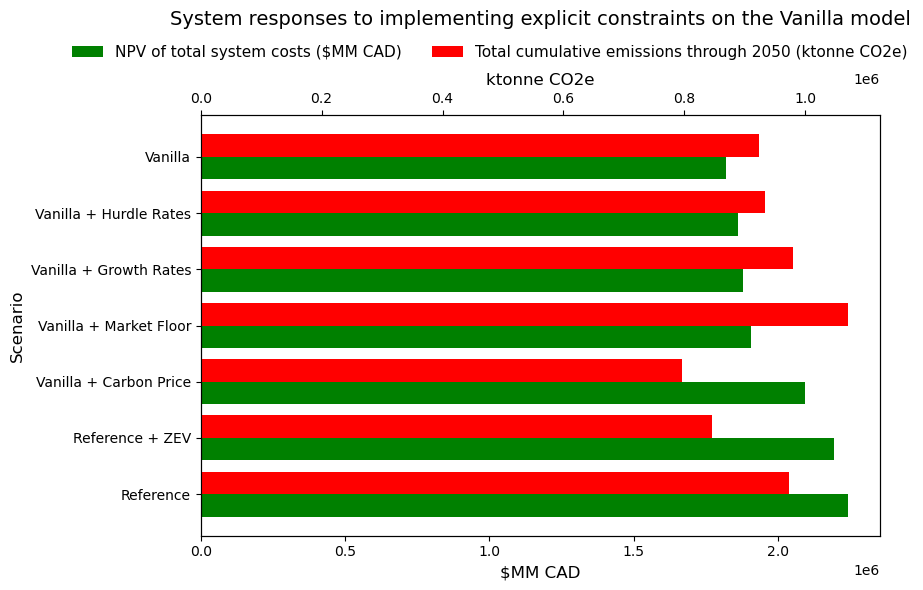

In [281]:
import matplotlib.pyplot as plt

# Plotting the results in a horizontal orientation
fig, ax1 = plt.subplots(figsize=(9, 6))

# Bar width and positions
bar_width = 0.4
index = range(len(df_vanilla))

# Bar plots with a horizontal orientation
ax1.barh(index, df_vanilla['system_costs'], bar_width, label='NPV of total system costs ($MM CAD)', color='green')
ax2 = ax1.twiny()  # Create a secondary x-axis
ax2.barh([i + bar_width for i in index], df_vanilla['system_emissions'], bar_width, label='Total cumulative emissions through 2050 (ktonne CO2e)', color='red')

# Labels, titles, and ticks adjustments
ax1.set_ylabel('Scenario', fontsize=12)
ax1.set_xlabel('$MM CAD', fontsize=12)
ax2.set_xlabel('ktonne CO2e', fontsize=12, labelpad=5)
ax1.set_title('System responses to implementing explicit constraints on the Vanilla model', pad=65, fontsize=14)
ax1.set_yticks([i + bar_width / 2 for i in index])
ax1.set_yticklabels(df_vanilla['scenario'], rotation=0, ha='right')

# Remove duplicate grid lines by aligning the grids
ax1.grid(False)
ax2.grid(False)

# Adding legends to the plot and adjusting placement to avoid overlap
fig.legend(loc='upper center', bbox_to_anchor=(0.55, 0.94), ncol=2, frameon=False, fontsize=11)

# Save the figure as an SVG file
plt.tight_layout()
plt.savefig('constraints.svg', format='svg')

# Display the plot
plt.show()
